In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm, gamma
import seaborn as sns
sns.set(font='IPAexGothic')
plt.style.use("ggplot")
import japanize_matplotlib
from itertools import product
from sklearn.mixture import GaussianMixture
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv("Davis.csv", index_col=0, header=0)
df

,sex,weight,height,repwt,repht
1,M,77,182,77.0,180.0
2,F,58,161,51.0,159.0
3,F,53,161,54.0,158.0
4,M,68,177,70.0,175.0
5,F,59,157,59.0,155.0
...,...,...,...,...,...
196,M,74,175,71.0,175.0
197,M,83,180,80.0,180.0
198,M,81,175,NaN,NaN
199,M,90,181,91.0,178.0


In [25]:
# ====== Davisデータの読み込み ======
weight = df["weight"].astype(float).to_numpy()

In [26]:
# ====== 実行例3.1: モーメント法 & 最尤法 ======
N = len(weight)                    # 標本数
mu = weight.mean()                 # 標本平均
si = weight.std(ddof=0)             # 母標準偏差

# モーメント法 (k, s)  ここで s は scale(=θ)
kmo = (mu / si) ** 2              # k = (μ/σ)^2
smo = (si ** 2) / mu              # s = σ^2 / μ

# 最尤法 (scipyのGammaは shape=a, loc, scale=θ)
# Rの"MASS::fitdistr(..., 'gamma')"はloc=0のガンマ（rate推定）に相当するので floc=0 で合わせます
kml, loc_mle, sml = gamma.fit(weight, floc=0)  # k=shape, loc=0, s=scale(=θ)
# Rのsmlは 1/rate なので、scipyの scale がそのまま s(=θ) に対応

print("MoM estimates: kmo, smo =", kmo, smo)#モーメント法によるパラメータ推定値
print("MLE estimates: kml, sml =", kml, sml)#最尤推定によるパラメータ推定値

MoM estimates: kmo, smo = 19.096859562455887 3.4455927051671735
MLE estimates: kml, sml = 22.48530359200564 2.926355863097812


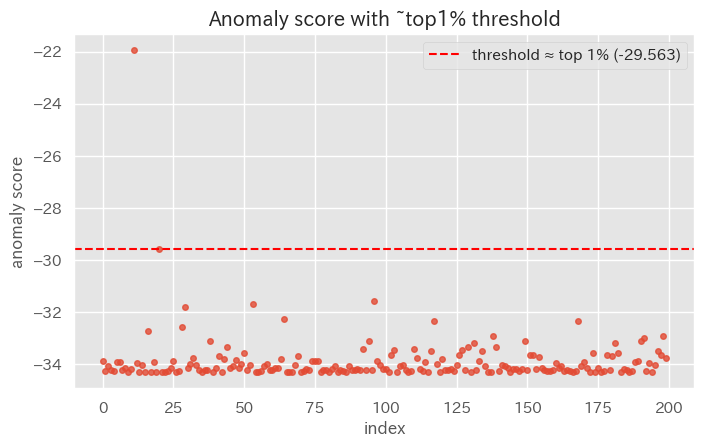

In [27]:
# ====== 実行例3.2: 異常度としきい値（上位1%） ======
# a = x/smo - (kmo - 1) * log(x/smo)　負の対数尤度
a = weight / smo - (kmo - 1) * np.log(weight / smo)#異常度

# Rの: th <- order(a, decreasing = T)[0.01*N]
# → 降順に並べたときの「上位1%番目」の値をしきい値にするイメージ
a_sorted_desc = np.sort(a)[::-1]
idx = int(np.floor(0.01 * N)) - 1   # Rは1始まり, Pythonは0始まり
if idx < 0:
    idx = 0
th_val = a_sorted_desc[idx]

plt.style.use("ggplot")  # ggplot風スタイル
plt.figure(figsize=(8, 4.6))
plt.plot(a, "o", ms=4, alpha=0.8)
plt.axhline(th_val, color="red", linestyle="--", label=f"threshold ≈ top 1% ({th_val:.3f})")
plt.xlabel("index")
plt.ylabel("anomaly score")
plt.title("Anomaly score with ~top1% threshold")
plt.legend()
plt.show()

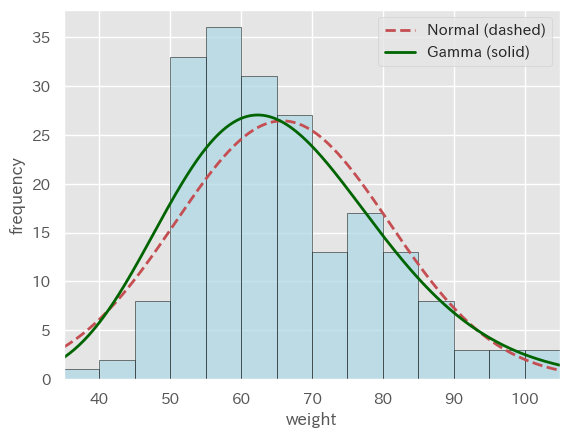

In [28]:
# ====== ヒストグラム（度数）と理論曲線（度数スケール） ======
# Rの var() は分母(n-1)なので、ここも ddof=1 で合わせます
s2 = weight.var(ddof=1)
sigma = np.sqrt(s2)
n = N

# ヒストグラム（度数）
counts, bins, patches = plt.hist(
    weight, bins=14, range=(35, 105),
    color="lightblue", edgecolor="black", alpha=0.7
)
bin_width = bins[1] - bins[0]

# x軸（理論曲線用）
x = np.linspace(35, 105, 300)

# 正規分布（破線, 度数スケールに換算：density × n × bin_width）
y_norm = norm.pdf(x, loc=mu, scale=sigma) * n * bin_width
plt.plot(x, y_norm, "r--", linewidth=2, label="Normal (dashed)")

# ガンマ分布（実線, モーメント法の shape/scale でRの式を再現）
shape_mom = (mu/sigma)**2  # Rコードの shape <- mu^2 / s2 （s2は分母n-1の分散）
scale_mom = (sigma**2) / mu
y_gamma = gamma.pdf(x, a=shape_mom, scale=scale_mom) * n * bin_width
plt.plot(x, y_gamma, color="darkgreen", linewidth=2, label="Gamma (solid)")

plt.xlim(35, 105)
plt.xlabel("weight")
plt.ylabel("frequency")
plt.legend()
plt.show()

In [29]:
# ===== 実行例3.3: データ生成（2成分正規の混合） =====
N   = 1000  # 標本数
pi0 = 0.6
pi1 = 0.4
mu0 = 3.0
mu1 = 0.0
sig0 = 0.5
sig1 = 3.0

rng = np.random.default_rng(0)  # 再現性のための乱数シード（任意）

# 各標本の（真の）出身をサンプリング
attr = rng.choice([0, 1], size=N, replace=True, p=[pi0, pi1])

# 観測値ベクトル x を生成
x = np.empty(N, dtype=float)
x[attr == 0] = rng.normal(loc=mu0, scale=sig0, size=(attr == 0).sum())#0 出身
x[attr == 1] = rng.normal(loc=mu1, scale=sig1, size=(attr == 1).sum())#1 出身

In [30]:
# ===== 実行例3.4: EMアルゴリズム（10反復） =====
# ここでは R と同様に上の値を初期値として使います（任意で変更可）
for iteration in range(10):
    # E-step: 責任度（各点が各成分に属する確率）を計算
    piN0 = pi0 * norm.pdf(x, loc=mu0, scale=sig0)
    piN1 = pi1 * norm.pdf(x, loc=mu1, scale=sig1)
    denom = piN0 + piN1 + 1e-12  # 0割回避の微小量
    qn0 = piN0 / denom
    qn1 = piN1 / denom

    # M-step: 責任度を重みにパラメータ更新
    Nk0 = qn0.sum()
    Nk1 = qn1.sum()
    pi0 = Nk0 / N
    pi1 = Nk1 / N

    mu0 = (qn0 * x).sum() / Nk0
    mu1 = (qn1 * x).sum() / Nk1

    sig0 = np.sqrt((qn0 * (x - mu0) ** 2).sum() / Nk0)
    sig1 = np.sqrt((qn1 * (x - mu1) ** 2).sum() / Nk1)

# 結果の確認（任意）
print(f"pi0={pi0:.3f}, mu0={mu0:.3f}, sig0={sig0:.3f}")
print(f"pi1={pi1:.3f}, mu1={mu1:.3f}, sig1={sig1:.3f}")

pi0=0.585, mu0=3.027, sig0=0.510
pi1=0.415, mu1=-0.299, sig1=3.136


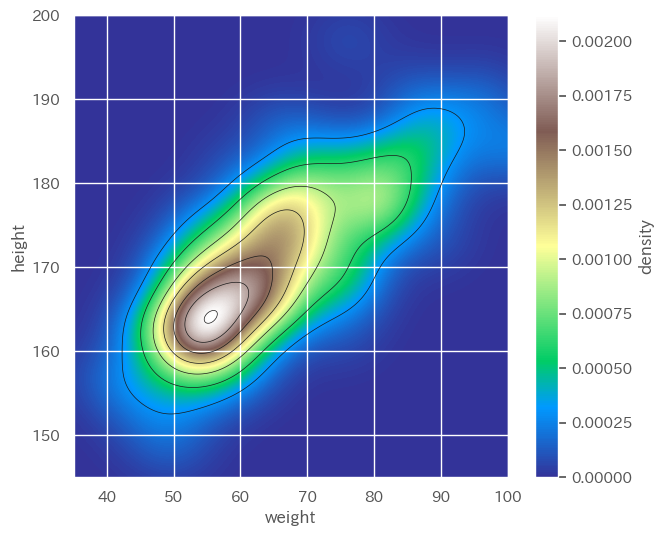

In [31]:
# ==== 実行例3.5: 2次元KDE(カーネル密度推定)を格子上で計算（ガウス積カーネル）====
x = df[["weight", "height"]].astype(float).to_numpy()
w = x[:, 0]
h = x[:, 1]
n = x.shape[0]

# ==== 1次元バンド幅（Rの dpik の代替として Silverman を採用）====
def bw_silverman(v):
    v = np.asarray(v)
    std = np.std(v, ddof=1)
    iqr = np.subtract(*np.percentile(v, [75, 25]))
    sigma = min(std, iqr / 1.34) if iqr > 0 else std #Silvermanの経験則
    return 0.9 * sigma * n ** (-1/5) #Silvermanの経験則

#各方向のバンド幅を求める
h1 = bw_silverman(w)
h2 = bw_silverman(h)
bandwidth = np.array([h1, h2])


# グリッド（Rの gridsize=c(1000,1000) 相当。計算負荷が高い点に注意）
gx, gy = 1000, 1000
xgrid = np.linspace(35, 100, gx)   # xlimに合わせる
ygrid = np.linspace(145, 200, gy)  # ylimに合わせる
Xg, Yg = np.meshgrid(xgrid, ygrid)

# 密度推定： fhat(u,v) = (1/n) * sum K((u-w_i)/h1)/h1 * K((v-h_i)/h2)/h2
# 直接ベクトル化するとメモリが厳しいため、x方向をバッチ処理
def gaussian_kernel(u):
    return (1 / np.sqrt(2*np.pi)) * np.exp(-0.5 * u**2)#標準正規分布の密度関数

fhat = np.zeros_like(Xg, dtype=float)

# バッチ数は環境に応じて調整可（速度とメモリの兼ね合い）
batch = 50
for start in range(0, gx, batch):
    end = min(start + batch, gx)
    # (end-start, gy, n)　
    U = (Xg[:, start:end][None, :, :] - w[:, None, None]) / h1   # shape: (n, gy, bx)　bx = end-start ≤ 50
    V = (Yg[:, start:end][None, :, :] - h[:, None, None]) / h2
    Ku = gaussian_kernel(U) / h1
    Kv = gaussian_kernel(V) / h2
    # 各点で n 個の積の平均
    # 転置して (gy, bx, n) にしてから積→和→平均
    prod = (Ku * Kv).transpose(1, 2, 0)   # (gy, bx, n)
    fhat[:, start:end] = prod.mean(axis=2)

# 画像表示（Rの image + contour）
plt.figure(figsize=(7, 6))
plt.imshow(fhat,
           extent=[xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()],
           origin="lower",
           aspect="auto",
           cmap="terrain")
plt.colorbar(label="density")
plt.contour(xgrid, ygrid, fhat, colors="k", linewidths=0.5)
plt.xlim(35, 100)
plt.ylim(145, 200)
plt.xlabel("weight")
plt.ylabel("height")
#plt.title("2D KDE (Gaussian product kernel)")
plt.show()

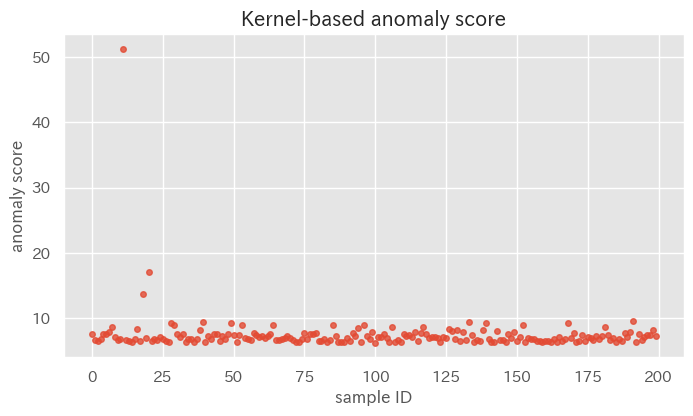

In [32]:
# ==== 実行例3.6: カーネル行列 K を作成し異常度を計算 ====
# K_ij = [k((w_i - w_j)/h1)/h1] * [k((h_i - h_j)/h2)/h2]
D1 = (w[:, None] - w[None, :]) / h1
D2 = (h[:, None] - h[None, :]) / h2
K = (gaussian_kernel(D1) / h1) * (gaussian_kernel(D2) / h2)

# 自分自身の寄与を除いた近傍密度の推定量（列合計から対角を引く）
aa = K.sum(axis=0) - np.diag(K)

# 下限クリップ
lowerLim = 1e-20
aa = np.maximum(aa, lowerLim)

# 異常度（R: a <- (-1)*log(aa/(n-1))）
a = -np.log(aa / (n - 1))

plt.figure(figsize=(8, 4.2))
plt.plot(a, "o", ms=4, alpha=0.8)
plt.xlabel("sample ID")
plt.ylabel("anomaly score")
plt.title("Kernel-based anomaly score")
plt.show()

In [33]:
# ==== 実行例3.7: 混合正規分布モデルのクラスタリング====
X_full = df[["weight", "height"]].astype(float).to_numpy()

# Rの -12 は 1-based の 12 番目除去 → Python 0-based では index=11 を除外
mask = np.ones(len(X_full), dtype=bool)
mask[11] = False
X_train = X_full[mask]

# BIC最小モデルを探索
cov_types = ['full', 'tied', 'diag', 'spherical']
# full:成分ごとに自由な２×２共分散行列
# tied:全成分で共通の共分散（２×２）
# diag:各成分で対角成分のみ（相関なし）
# 各成分が球状（共分散=σ2I）
n_components_grid = range(1, 7)

best_model = None
best_bic = np.inf
bic_records = []

for cov, n_comp in product(cov_types, n_components_grid):
    gm = GaussianMixture(n_components=n_comp, covariance_type=cov, random_state=0)
    gm.fit(X_train)
    bic = gm.bic(X_train)
    bic_records.append((cov, n_comp, bic))
    if bic < best_bic:
        best_bic = bic
        best_model = gm

# BIC一覧の表示（小さいほど良い）
bic_df = pd.DataFrame(bic_records, columns=["covariance_type", "n_components", "BIC"]).sort_values("BIC")
print("=== BIC ranking (lower is better) ===")
print(bic_df.head(10).to_string(index=False))

=== BIC ranking (lower is better) ===
covariance_type  n_components         BIC
           full             2 2863.751724
           tied             2 2868.754722
           full             1 2878.000429
           tied             1 2878.000429
           tied             3 2881.951324
           full             3 2888.892241
           tied             4 2894.366218
           full             4 2897.524780
           diag             3 2898.086381
           tied             5 2899.618815


In [34]:
# 採用モデルの要約（mclust::summary 相当）
print("\n=== Selected model summary ===")
print(f"covariance_type: {best_model.covariance_type}")
print(f"n_components  : {best_model.n_components}")
print("weights_ (pi) :", np.round(best_model.weights_, 4))
print("means_ (mu)   :\n", np.round(best_model.means_, 4))
if best_model.covariance_type == 'full':
    print("covariances_ (full):")
    for k, C in enumerate(best_model.covariances_):
        print(f"  comp {k}:\n{np.round(C, 4)}")
else:
    print("covariances_ :", np.round(best_model.covariances_, 4))


=== Selected model summary ===
covariance_type: full
n_components  : 2
weights_ (pi) : [0.3794 0.6206]
means_ (mu)   :
 [[ 77.6307 178.0455]
 [ 57.7546 166.028 ]]
covariances_ (full):
  comp 0:
[[143.4987  43.0999]
 [ 43.0999  49.3828]]
  comp 1:
[[47.8282 30.5716]
 [30.5716 43.4048]]


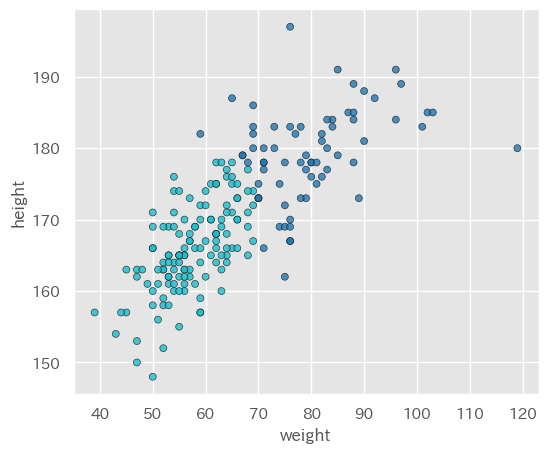

In [35]:
# ラベル予測（可視化用）
labels = best_model.predict(X_train)

# 簡易可視化（Rの plot(result) のクラスタ散布に相当）
plt.figure(figsize=(6,5))
plt.scatter(X_train[:,0], X_train[:,1], c=labels, cmap="tab10", s=25, edgecolors="k", alpha=0.8)
plt.xlabel("weight"); plt.ylabel("height")
plt.show()

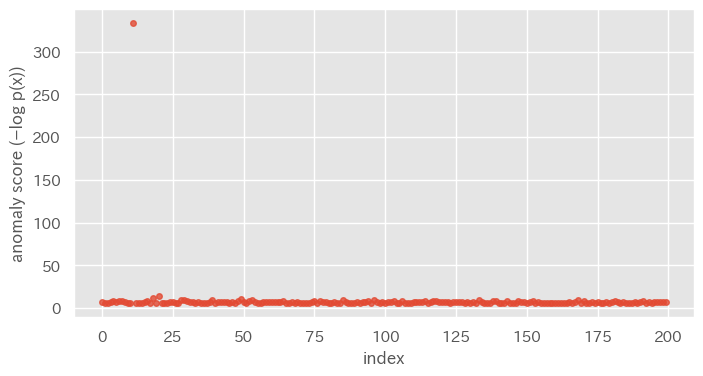


Estimated mixture proportions (pi): [0.3794 0.6206]


In [36]:
# ==== 実行例3.8: 全データ（12番目を含む）で異常度を計算 ====
# mclustの a = -log( cdens %*% pi ) に対応 → sklearn は log p(x) を直接返す
log_mix_pdf = best_model.score_samples(X_full)  # shape (n,), log p(x)
a = -log_mix_pdf                                # 異常度

plt.figure(figsize=(8,4))
plt.plot(a, "o", ms=4, alpha=0.8)
plt.xlabel("index"); plt.ylabel("anomaly score (−log p(x))")
plt.show()

# 参考：混合比 pi を取り出す（R: result$parameters$pro）
pi_hat = best_model.weights_
print("\nEstimated mixture proportions (pi):", np.round(pi_hat, 4))

In [38]:
# ===== 実行例3.9: データ生成 & 標準化 =====
rng = np.random.default_rng(0)

# Rのrbind(matrix(rnorm(120), ncol=2), matrix(rnorm(120, mean=3), ncol=2))
# → 60x2 を2つ結合して 120x2
x1 = rng.normal(loc=0.0, scale=1.0, size=(60, 2))
x2 = rng.normal(loc=3.0, scale=1.0, size=(60, 2))
X = np.vstack([x1, x2])

# 標準化（Rの scale(x)）
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

# RBFカーネルの one-class SVM（kernlab: rbfdot(sigma=0.5), nu=0.1）
ocsvm = OneClassSVM(kernel="rbf", gamma=0.5, nu=0.1)
ocsvm.fit(Xz)

OneClassSVM(gamma=0.5, nu=0.1)

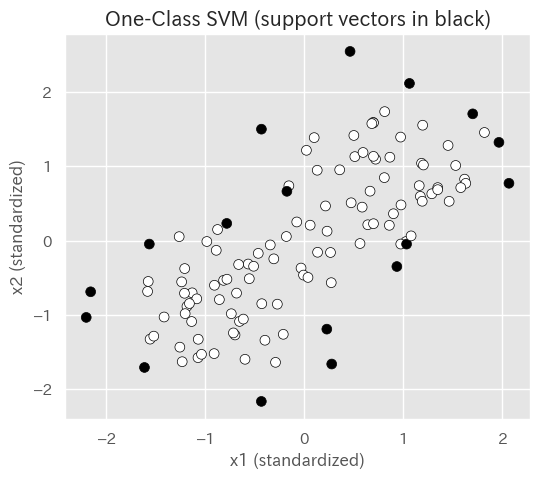

In [39]:
# ===== 実行例3.10: 支持ベクトルの可視化 =====
colorcode = np.zeros(len(Xz), dtype=int)
colorcode[ocsvm.support_] = 1  # 支持ベクトルを1に

plt.figure(figsize=(6, 5))
plt.scatter(
    Xz[:, 0], Xz[:, 1],
    c=np.where(colorcode == 1, "black", "white"),
    edgecolors="black", s=50
)
plt.xlabel("x1 (standardized)")
plt.ylabel("x2 (standardized)")
plt.title("One-Class SVM (support vectors in black)")
plt.show()

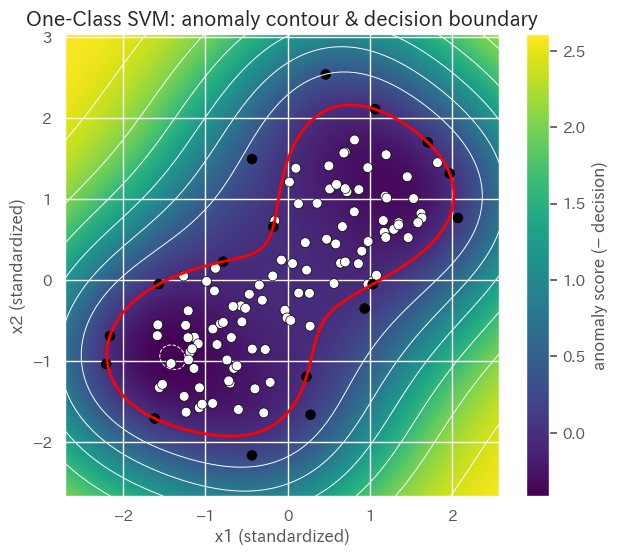

In [40]:
# ===== 追加：異常度ヒートマップ＋等高線（決定境界=0） =====
# 1) グリッド生成（データ範囲に少し余白）
rx1 = (Xz[:, 0].min(), Xz[:, 0].max())
rx2 = (Xz[:, 1].min(), Xz[:, 1].max())
gx1 = np.linspace(rx1[0] - 0.5, rx1[1] + 0.5, 200)
gx2 = np.linspace(rx2[0] - 0.5, rx2[1] + 0.5, 200)
GX1, GX2 = np.meshgrid(gx1, gx2)
grid = np.c_[GX1.ravel(), GX2.ravel()]

# 2) decision 値 → 異常度（大きいほど異常）
#    scikit-learn: decision_function > 0 が「内側（正常）」、< 0 が「外側（異常）」
dec = ocsvm.decision_function(grid).reshape(GX1.shape)
anom = -dec  # Rと同様に「大きいほど異常」に反転

# 3) 背景に異常度のヒートマップ、上に等高線 & 決定境界(=0)
plt.figure(figsize=(7, 6))
plt.imshow(
    anom, extent=[gx1.min(), gx1.max(), gx2.min(), gx2.max()],
    origin="lower", aspect="auto", cmap="viridis"
)
plt.colorbar(label="anomaly score (− decision)")

# 等高線（ラベル無し）
plt.contour(gx1, gx2, anom, colors="white", linewidths=0.7)

# 決定境界（decision=0）
plt.contour(gx1, gx2, dec, levels=[0.0], colors="red", linewidths=2)

# 4) データ点（支持ベクトルを黒塗り）
plt.scatter(
    Xz[:, 0], Xz[:, 1],
    c=np.where(colorcode == 1, "black", "white"),
    edgecolors="black", s=50
)

plt.xlabel("x1 (standardized)")
plt.ylabel("x2 (standardized)")
plt.title("One-Class SVM: anomaly contour & decision boundary")
plt.show()